# Inventory Management

### Libraries import


In [1]:
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD

In [2]:
# read the data
df = pd.read_csv("data.csv")

In [3]:
df.head()

,DIVISION,OPERATION_ID,ACCOUNT_ID,UNIQUE_MARKET_ID,MARKET_INDUSTRY,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_NAME,TRANSACTION_DATE,TRANSACTION_DAYPART,QUANTITY_SOLD,PRODUCT_SALES_AMOUNT
0,Southwest,204,357080,302836,Chemical/Pharmaceutical,Energy,5509,Red Bull Energy Drink (8.4oz),2023-08-25,Breakfast,2,8.654151
1,Southwest,202,465931,315344,Chemical/Pharmaceutical,Energy,5509,Red Bull Energy Drink (8.4oz),2023-08-25,Breakfast,1,4.462720
2,Southwest,206,569363,275810,Chemical/Pharmaceutical,Energy,19438,Monster Energy Zero Ultra (16oz),2023-08-25,Breakfast,1,4.462720
3,Southwest,204,385746,278594,Chemical/Pharmaceutical,Energy,5488,Red Bull Sugar Free Energy Drink (8.4oz),2023-08-25,Breakfast,1,4.327076
4,Southwest,204,196063,277077,Chemical/Pharmaceutical,Energy,3474,Monster Energy (16oz),2023-08-25,Breakfast,1,5.140945


### Data cleaning and sanity check

In [4]:
# check na
df.isna().sum()

DIVISION                0
OPERATION_ID            0
ACCOUNT_ID              0
UNIQUE_MARKET_ID        0
MARKET_INDUSTRY         0
PRODUCT_CATEGORY        0
PRODUCT_ID              0
PRODUCT_NAME            0
TRANSACTION_DATE        0
TRANSACTION_DAYPART     0
QUANTITY_SOLD           0
PRODUCT_SALES_AMOUNT    0
dtype: int64

In [5]:
# check duplicates
df[df.duplicated(keep=False)]

,DIVISION,OPERATION_ID,ACCOUNT_ID,UNIQUE_MARKET_ID,MARKET_INDUSTRY,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_NAME,TRANSACTION_DATE,TRANSACTION_DAYPART,QUANTITY_SOLD,PRODUCT_SALES_AMOUNT
689027,Northwest,254,278450,148432,Manufacturing,Soda,5251,Sprite (20oz),2023-08-14,Evening,1,2.83498
689364,Northwest,254,278450,148432,Manufacturing,Soda,5251,Sprite (20oz),2023-08-14,Evening,1,2.83498


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749999 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   DIVISION              749999 non-null  object 
 1   OPERATION_ID          749999 non-null  int64  
 2   ACCOUNT_ID            749999 non-null  int64  
 3   UNIQUE_MARKET_ID      749999 non-null  int64  
 4   MARKET_INDUSTRY       749999 non-null  object 
 5   PRODUCT_CATEGORY      749999 non-null  object 
 6   PRODUCT_ID            749999 non-null  int64  
 7   PRODUCT_NAME          749999 non-null  object 
 8   TRANSACTION_DATE      749999 non-null  object 
 9   TRANSACTION_DAYPART   749999 non-null  object 
 10  QUANTITY_SOLD         749999 non-null  int64  
 11  PRODUCT_SALES_AMOUNT  749999 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 74.4+ MB


In [8]:
# convert date from string to date format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE']).dt.date
# general statistics about data
df[['QUANTITY_SOLD','PRODUCT_SALES_AMOUNT']].describe()

,QUANTITY_SOLD,PRODUCT_SALES_AMOUNT
count,749999.000000,749999.000000
mean,1.371938,3.662921
std,0.902175,2.594441
min,1.000000,0.000000
25%,1.000000,2.156756
50%,1.000000,2.767158
75%,1.000000,4.462720
max,36.000000,97.664400


- The median and 75 percentile of 'QUANTITY_SOLD' is 1 meaning majority of the customers by only one product
- The minimum of PRODUCT_SALES_AMOUNT is 0.0
- The median sales per transaction is around 2.76

In [9]:
df[df['PRODUCT_SALES_AMOUNT'] == 0.0]

,DIVISION,OPERATION_ID,ACCOUNT_ID,UNIQUE_MARKET_ID,MARKET_INDUSTRY,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_NAME,TRANSACTION_DATE,TRANSACTION_DAYPART,QUANTITY_SOLD,PRODUCT_SALES_AMOUNT
138174,Southwest,201,259049,257542,Distribution Centers,Salty Snacks,6214,Lays Sour Cream & Onion Chips (1.5oz),2023-08-15,Lunch,1,0.0
138880,Southwest,201,259049,257542,Distribution Centers,Salty Snacks,6214,Lays Sour Cream & Onion Chips (1.5oz),2023-08-15,Late Afternoon,1,0.0
329982,Southwest,201,259049,257542,Distribution Centers,Salty Snacks,6214,Lays Sour Cream & Onion Chips (1.5oz),2023-08-14,Lunch,1,0.0
397302,Southwest,201,259049,257542,Distribution Centers,Salty Snacks,6214,Lays Sour Cream & Onion Chips (1.5oz),2023-08-16,Lunch,1,0.0
543065,Southwest,201,259049,257542,Distribution Centers,Salty Snacks,6214,Lays Sour Cream & Onion Chips (1.5oz),2023-08-20,Lunch,1,0.0


* Upon further looking, there is a problem with UNIQUE_MARKET_ID = 257542 and PRODUCT_NAME = Lays Sour Cream & Onion Chips (1.5oz)
* It may be due to system error, data entry error, etc.

In [10]:
# dropping where sales amount = 0.0
df.drop(df[df['PRODUCT_SALES_AMOUNT']==0.0].index,inplace=True)

In [11]:
# Distinct number of markets
df['UNIQUE_MARKET_ID'].nunique()

3402

### Comparing sales volumes and distribution for categorical columns

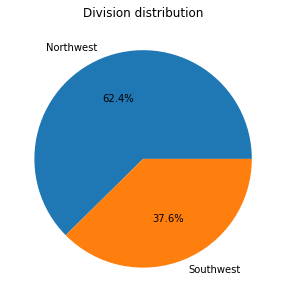

In [13]:
plot_pie(df.copy(),'DIVISION','Division distribution',(5,5))

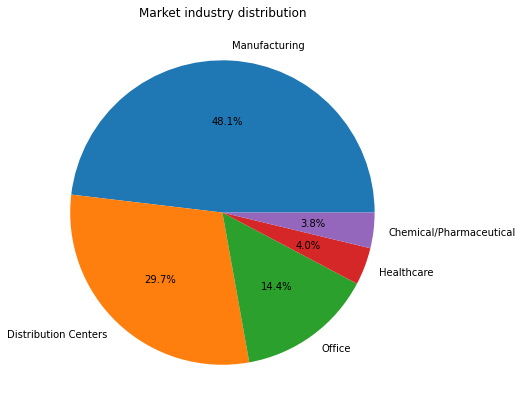

In [14]:
plot_pie(df.copy(),'MARKET_INDUSTRY','Market industry distribution',(7,7))

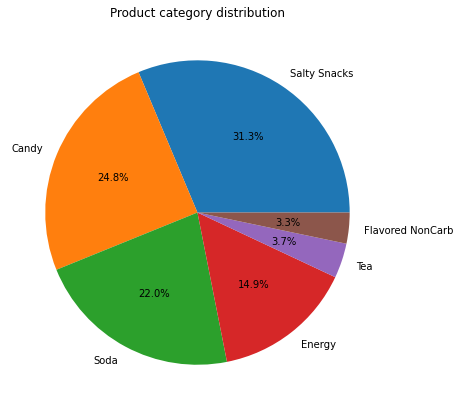

In [15]:
plot_pie(df.copy(),'PRODUCT_CATEGORY','Product category distribution',(7,7))

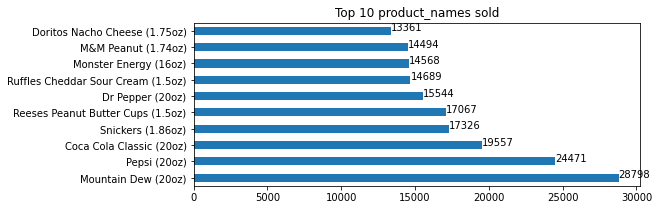

In [16]:
plt.figure(figsize = (8,3))
plt.title('Top 10 product_names sold')
df['PRODUCT_NAME'].value_counts().head(10).plot(kind='barh')
for index, value in enumerate(df['PRODUCT_NAME'].value_counts().head(10).to_dict().values()):
        plt.text(value, index,str(value))

**Individually** sodas are the most sold items as per PRODUCT_NAME but **collectively** Salty Snacks are the most sold as per the count of PRODUCT_CATEGORY. Lets look at the distinct items in both the category. 

Text(1, 379, '379')

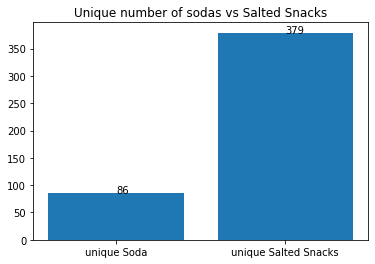

In [17]:
plt.title('Unique number of sodas vs Salted Snacks')
unique_soda = df[df['PRODUCT_CATEGORY']=='Soda']['PRODUCT_NAME'].nunique()
unique_salted_snacks = df[df['PRODUCT_CATEGORY']=='Salty Snacks']['PRODUCT_NAME'].nunique()
x = ['unique Soda','unique Salted Snacks']
y = [unique_soda,unique_salted_snacks]
plt.bar(x,y)
plt.text(0, y[0],str(y[0]))
plt.text(1, y[1],str(y[1]))

- Thus, we should increase the distinct sodas and sodas are a must keep for any demographic.

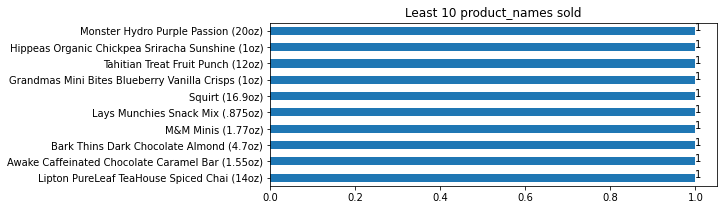

In [18]:
plt.figure(figsize = (8,3))
plt.title('Least 10 product_names sold')
df['PRODUCT_NAME'].value_counts()[-10:].plot(kind='barh')
for index, value in enumerate(df['PRODUCT_NAME'].value_counts()[-10:].to_dict().values()):
        plt.text(value, index,str(value))

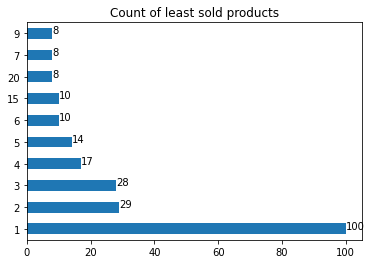

In [19]:
plt.title('Count of least sold products')
count_of_product_series = df.groupby('PRODUCT_NAME')['QUANTITY_SOLD'].sum()
count_of_product_series.rename('Total Quantity',inplace=True)
count_of_product_df = count_of_product_series.reset_index()
count_of_product_df['Total Quantity'].value_counts()[:10].plot(kind='barh')
for index, value in enumerate(count_of_product_df['Total Quantity'].value_counts()[:10].to_dict().values()):
        plt.text(value, index,str(value))

- Reducing the least used products, we can make space for products with higher demands

    August 2023
Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6
 7  8  9 10 11 12 13
14 15 16 17 18 19 20
21 22 23 24 25 26 27
28 29 30 31



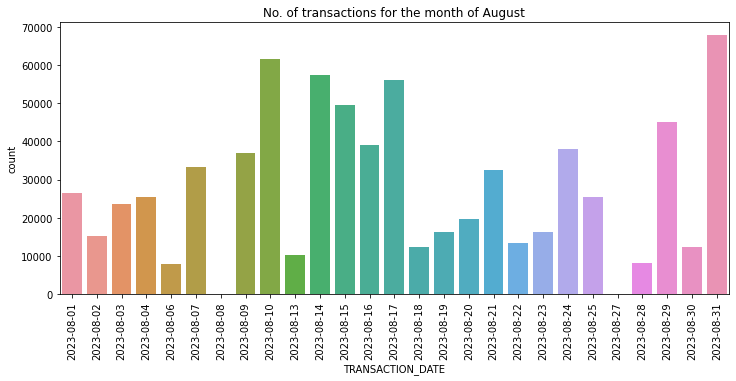

In [20]:
# No. of transactions for the month of August
plt.figure(figsize = (12,5))
plt.xticks(rotation=90)
ax = sns.countplot(x='TRANSACTION_DATE',data=df, order=sorted(df['TRANSACTION_DATE'].unique()))
print(calendar.month(2023,8))
plt.title('No. of transactions for the month of August');

- Every sat missing except 19, missing 11 - maybe stat holiday
- By knowing geographical location, we can know if holidays affect sales
- Less sales on sunday compared to other days of the week
- On an average Thursdays have higher sales compared to rest of the weekdays followed by Mondays

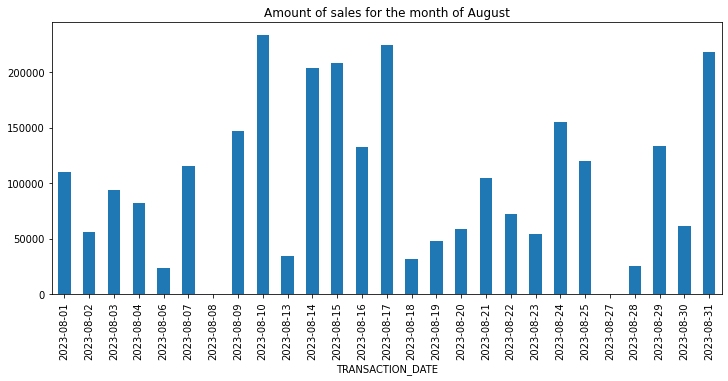

In [21]:
# Amount of sales for the month of August
plt.figure(figsize = (12,5))
sales_df = df.groupby('TRANSACTION_DATE')['PRODUCT_SALES_AMOUNT'].sum()
sales_df.plot.bar();
plt.title('Amount of sales for the month of August');

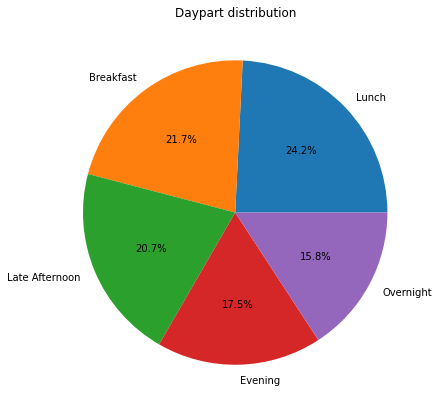

In [22]:
plot_pie(df.copy(),'TRANSACTION_DAYPART','Daypart distribution',(7,7))

- Lunch and Breakfast have higher sales which makes sense as the stores are at workplaces.

### Recommendation I: based on demographics and distribution - solves cold start problem

Comparing market industry, product category, product name, and sales among DIVISIONS and OPERATIONS

As the sales volume for Northwest is significant higher than Southwest, we will normalize the volumes to get true distribution of the MARKET_INDUSTRY.

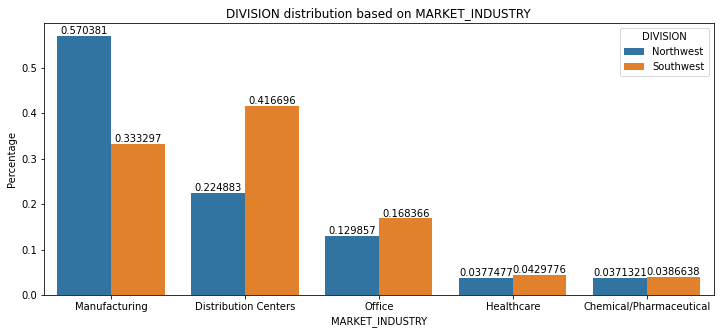

In [23]:
market_count_series = df.groupby('DIVISION')['MARKET_INDUSTRY'].value_counts(normalize=True)
market_count_series.rename('Percentage',inplace=True)
market_count_df = market_count_series.reset_index()

plt.figure(figsize = (12,5))
ax = sns.barplot(x='MARKET_INDUSTRY',hue='DIVISION', y='Percentage',data=market_count_df)
for i in ax.containers:
    ax.bar_label(i)
plt.title('DIVISION distribution based on MARKET_INDUSTRY');

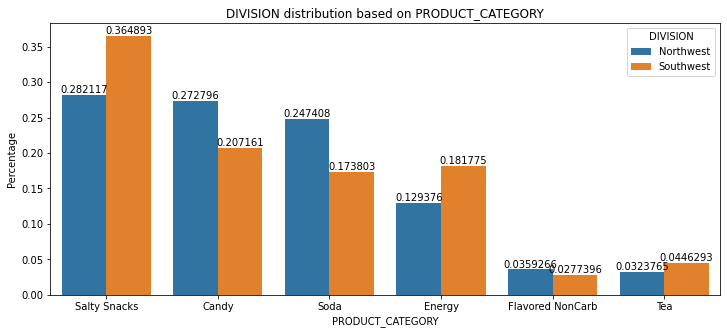

In [24]:
prd_cat_series = df.groupby('DIVISION')['PRODUCT_CATEGORY'].value_counts(normalize=True)
prd_cat_series.rename('Percentage',inplace=True)
prd_cat_df = prd_cat_series.reset_index()

plt.figure(figsize = (12,5))
ax = sns.barplot(x='PRODUCT_CATEGORY',hue='DIVISION', y='Percentage',data=prd_cat_df)
for i in ax.containers:
    ax.bar_label(i)
plt.title('DIVISION distribution based on PRODUCT_CATEGORY');

Diving deep into sales

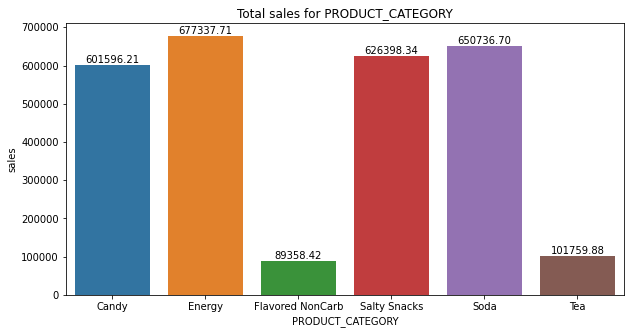

In [25]:
product_cat_sales_series = df.groupby(['PRODUCT_CATEGORY'])['PRODUCT_SALES_AMOUNT'].sum()
plt.figure(figsize = (10,5))
product_cat_sales_series.rename('sales',inplace=True)
product_cat_sales_df = product_cat_sales_series.reset_index()
ax = sns.barplot(x='PRODUCT_CATEGORY', y='sales',data=product_cat_sales_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
plt.title('Total sales for PRODUCT_CATEGORY');

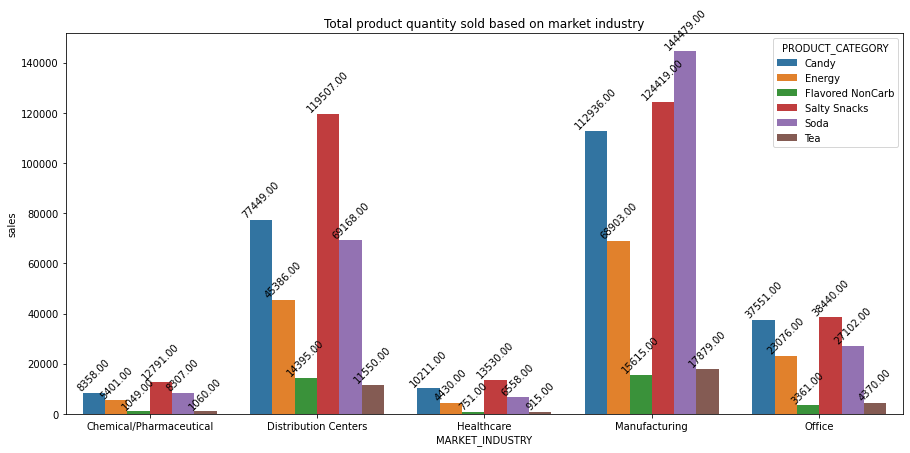

In [26]:
plt.figure(figsize = (15,7))
quantity_sold_series = df.groupby(['MARKET_INDUSTRY','PRODUCT_CATEGORY'])['QUANTITY_SOLD'].sum()
quantity_sold_series.rename('sales',inplace=True)
quantity_sold_df = quantity_sold_series.reset_index()
ax = sns.barplot(x='MARKET_INDUSTRY',hue='PRODUCT_CATEGORY', y='sales',data=quantity_sold_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f', rotation=45)
plt.title('Total product quantity sold based on market industry');

- Product stocking should be decided based on the above total sales of product category for particular indsutry. For instance, sodas for Manufacturing will get higher priority similar to salty snacks for healthcare

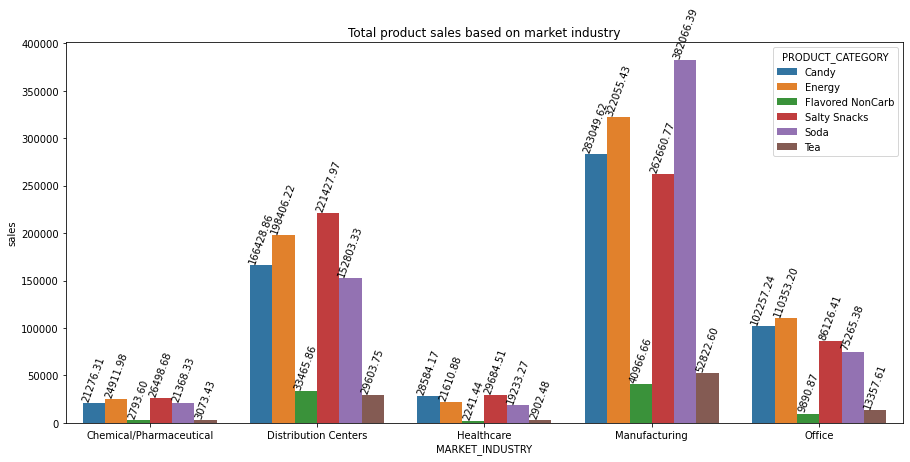

In [27]:
tdf_series = df.groupby(['MARKET_INDUSTRY','PRODUCT_CATEGORY'])['PRODUCT_SALES_AMOUNT'].sum()
plt.figure(figsize = (15,7))
tdf_series.rename('sales',inplace=True)
tdf = tdf_series.reset_index()
ax = sns.barplot(x='MARKET_INDUSTRY',hue='PRODUCT_CATEGORY', y='sales',data=tdf)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f', rotation=70)
plt.title('Total product sales based on market industry');

If a product is being sold less does not mean its not useful, if the individual price is higher, it would drive the sales up. For e.g. with energy drinks above where the quatity sold is less but sales are higher and not proportional

In [28]:
df['UNIT_PRICE'] = df['PRODUCT_SALES_AMOUNT']/df['QUANTITY_SOLD']

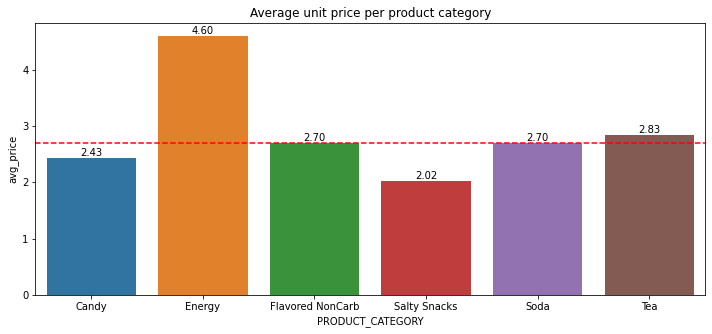

In [29]:
plt.figure(figsize = (12,5))
average_price_series = df.groupby('PRODUCT_CATEGORY')['UNIT_PRICE'].median()
average_price_series.rename('avg_price',inplace=True)
average_price_df = average_price_series.reset_index()
ax = sns.barplot(x='PRODUCT_CATEGORY',y='avg_price',data=average_price_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
ax.axhline(average_price_df["avg_price"].median(), ls='--', color="red");
plt.title('Average unit price per product category');

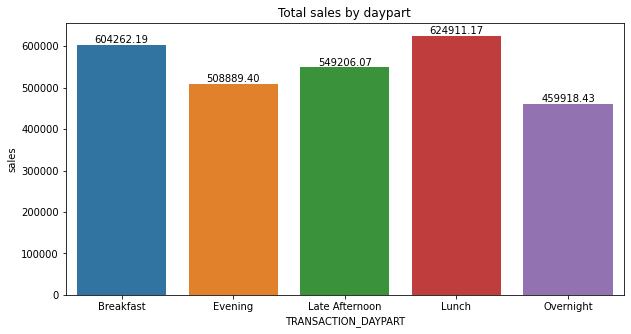

In [30]:
daypart_sales_series = df.groupby(['TRANSACTION_DAYPART'])['PRODUCT_SALES_AMOUNT'].sum()
plt.figure(figsize = (10,5))
daypart_sales_series.rename('sales',inplace=True)
daypart_sales_df = daypart_sales_series.reset_index()
ax = sns.barplot(x='TRANSACTION_DAYPART', y='sales',data=daypart_sales_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
plt.title('Total sales by daypart');

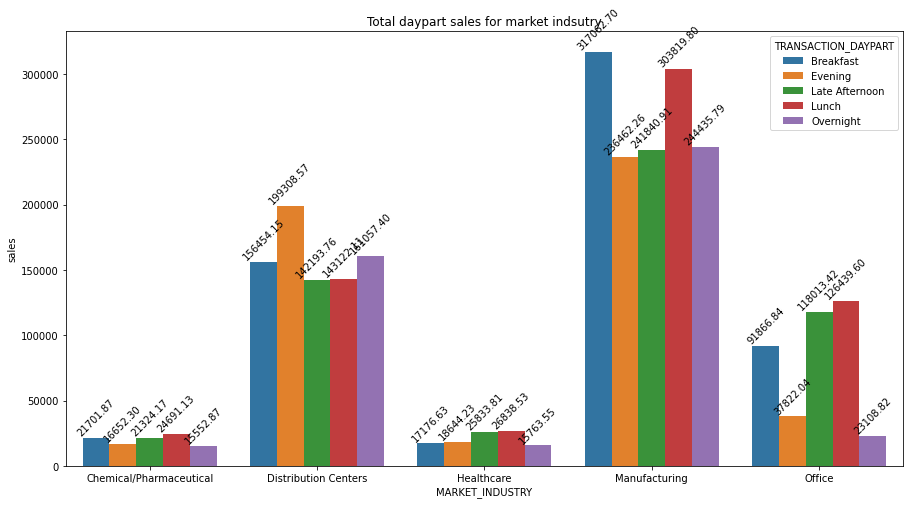

In [31]:
daypart_market_sales_series = df.groupby(['MARKET_INDUSTRY','TRANSACTION_DAYPART'])['PRODUCT_SALES_AMOUNT'].sum()
plt.figure(figsize = (15,8))
daypart_market_sales_series.rename('sales',inplace=True)
daypart_market_sales_df = daypart_market_sales_series.reset_index()
ax = sns.barplot(x='MARKET_INDUSTRY', hue='TRANSACTION_DAYPART', y='sales',data=daypart_market_sales_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f', rotation=45)
plt.title('Total daypart sales for market indsutry');

- Manufacturing industry spends higher during breakfast, maybe due to workplaces starting early in the morning?
- DIstribution center spends higher during evening, late working hours or rotating shifts?

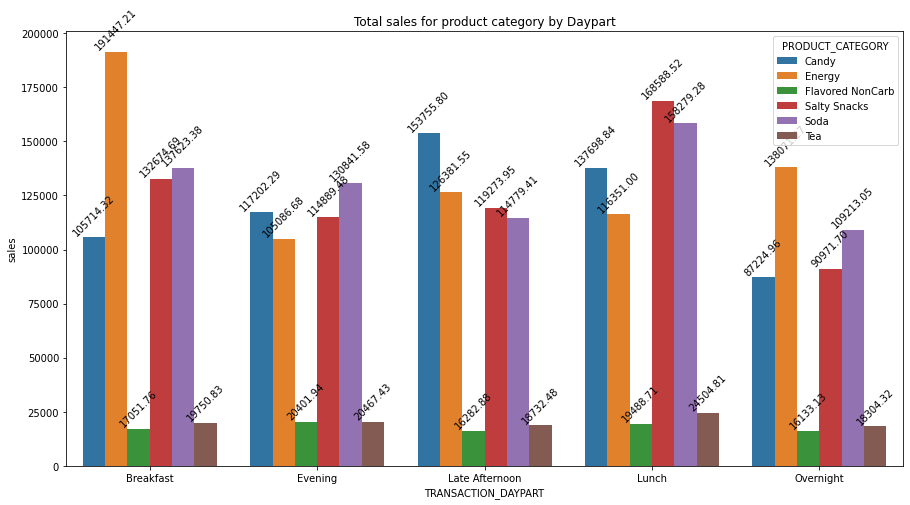

In [32]:
daypart_product_sales_series = df.groupby(['TRANSACTION_DAYPART','PRODUCT_CATEGORY'])['PRODUCT_SALES_AMOUNT'].sum()
plt.figure(figsize = (15,8))
daypart_product_sales_series.rename('sales',inplace=True)
daypart_product_sales_df = daypart_product_sales_series.reset_index()
ax = sns.barplot(x='TRANSACTION_DAYPART', hue='PRODUCT_CATEGORY', y='sales',data=daypart_product_sales_df)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f', rotation=45)
plt.title('Total sales for product category by Daypart');

- Combining the daypart and sales data we can adjust which particular product category to stock for the time of the day. For instance, one can increase the stock for energy drinks in manufacturing markets or salty snacks in Office marketplaces.

### Recommendation II: correlation based - helps with increase in sales

- Using collaboraing filtering to get the products which can serve as great substitute to items already sold at a particular store. The store-product matrix helps identify recommended substitutes based on sales data from other stores
- Popular items will be stocked with substitutes to prevent customer abandonment when certain products are unavailable. This ensures sales remain steady even if some items are in low supply

In [43]:
i = df.sample()['UNIQUE_MARKET_ID'].iloc[0]
print(f'Random market id {i}')

Random market id 250685


In [44]:
existing_products_list, recommended_products_list = recommend_products(250685,df.copy())

In [45]:
product_cat_mapping = df[['PRODUCT_NAME','PRODUCT_CATEGORY']].drop_duplicates()

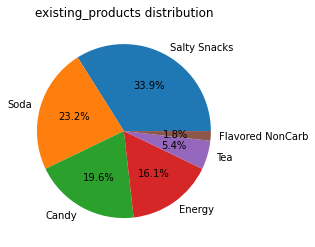

In [46]:
existing_products_list_df = pd.DataFrame()
existing_products_list_df['product'] = existing_products_list
join = pd.concat([existing_products_list_df.set_index('product'),product_cat_mapping.set_index('PRODUCT_NAME')], axis=1, join='inner').reset_index()
t = join['PRODUCT_CATEGORY'].value_counts().to_dict()
plt.pie(t.values(), labels=t.keys(), autopct='%1.1f%%')
plt.title('existing_products distribution')
plt.show()

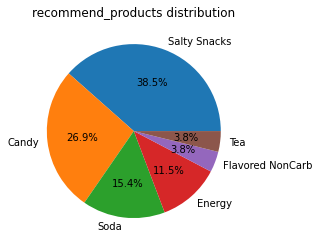

In [47]:
recommended_products_list_df = pd.DataFrame()
recommended_products_list_df['product'] = recommended_products_list
join = pd.concat([recommended_products_list_df.set_index('product'),product_cat_mapping.set_index('PRODUCT_NAME')], axis=1, join='inner').reset_index()
t = join['PRODUCT_CATEGORY'].value_counts().to_dict()
plt.pie(t.values(), labels=t.keys(), autopct='%1.1f%%')
plt.title('recommend_products distribution')
plt.show()

In [49]:
existing_products_list

['Red Bull Energy Drink (8.4oz)',
 'Reign Storm Harvest Grape (12oz)',
 'Monster Energy (16oz)',
 'NOS High Performance Energy Drink (16oz)',
 'Twix (1.79oz)',
 'Fruit Gushers Tropical (4.25oz)',
 'Dole Lemonade (20oz)',
 'Reeses Peanut Butter Cups (1.5oz)',
 'Cheetos Crunchy (2oz)',
 'Doritos Cool Ranch (1.75oz)',
 'Doritos Nacho Cheese (1.75oz)',
 'Lays Regular Chips (1.5oz)',
 'Doritos Sweet & Tangy BBQ (1.75oz)',
 'Doritos Spicy Sweet Chili (1.75oz)',
 'Lays Sour Cream & Onion Chips (1.5oz)',
 'Gold Peak Extra Sweet Tea (18.5oz)',
 'Lipton Green Tea with Citrus (20oz)',
 'Lipton Diet Green Tea with Citrus (20oz)',
 'Canada Dry Ginger Ale (20oz)',
 'Dr Pepper (20oz)',
 'Sun Drop (20oz)',
 'Pepsi (20oz)',
 'Mountain Dew (20oz)',
 'Celsius Sparkling Wildberry (12oz)',
 'Mountain Dew Code Red (20oz)',
 'Pepsi Wild Cherry (20oz)',
 'Cherry Coke (20oz)',
 'Coca Cola Classic (20oz)',
 'TGIF Cheddar Bacon Potato Skins (1.75oz)',
 'Pringles Scorchin BBQ (2.5oz)',
 'Ludicrous Insanely Season

In [48]:
recommended_products_list

['Welchs Mixed Fruit Snacks (2.25oz)',
 '5 Hour Energy Extra Strength Peach Mango (1.93oz)',
 'Cheerwine (20oz)',
 'Pringles Original (1.3oz)',
 'Reign Total Body Fuel Tropical Storm (16oz)',
 'Reign Storm Harvest Grape (12oz)',
 'Bugles Ranch (1.5oz)',
 'Minute Maid Fruit Punch (20oz)',
 'Chex Mix Bold Party (1.75oz)',
 'M&M Peanut (1.74oz)',
 'Cheezits (2oz)',
 'Haribo Gummi Peaches (4oz)',
 'Andy Capp Beer Battered Onion Rings (2oz)',
 'Ghirardelli Milk & Caramel Bar (3.5oz)',
 'Doritos Spicy Sweet Chili (1.75oz)',
 'Snickers (1.86oz)',
 'Doritos Nacho Cheese (1.75oz)',
 'Dr Pepper Cherry (20oz)',
 'Mountain Dew Baja Blast (20oz)',
 'Lays Regular Chips (1.5oz)',
 'Doritos Cool Ranch (1.75oz)',
 'Tribe Tea Raspberry Tea (20oz)',
 'Utz Extra Thin Pretzels (2.125oz)',
 'Sun Drop (20oz)',
 'Boyer Milk Chocolate Mallo Cup (1.5oz)',
 "DeMet's Turtles Original (1.76oz)"]

### Recommendation III: forecasting - helps with accurate demand prediction with the help of seasonsal trends

- There are products which were sold only twice in the month of August
- Out of all the products, the most one was sold was for 11 days in the month of August
- Taking monthly average for forecasting would lead to poor performance as it does not capture weekly trends
- Due to many zero-values due to no sales on certain days, methods like arima would require interpolation
- Better to have one model per product category rather than one model per product

The system consist of 3 engines: 
1) Product selection based on popular demand and sales, does not change much within market industry. Helps with introducing new stores (i.e. Recommendation I)

2) Recommender system which is unique for each store. Helps with substitution to increase growth (i.e. Recommendation II) 

3) Forecasting if we have access to more data (i.e. Recommendation III)

## System design

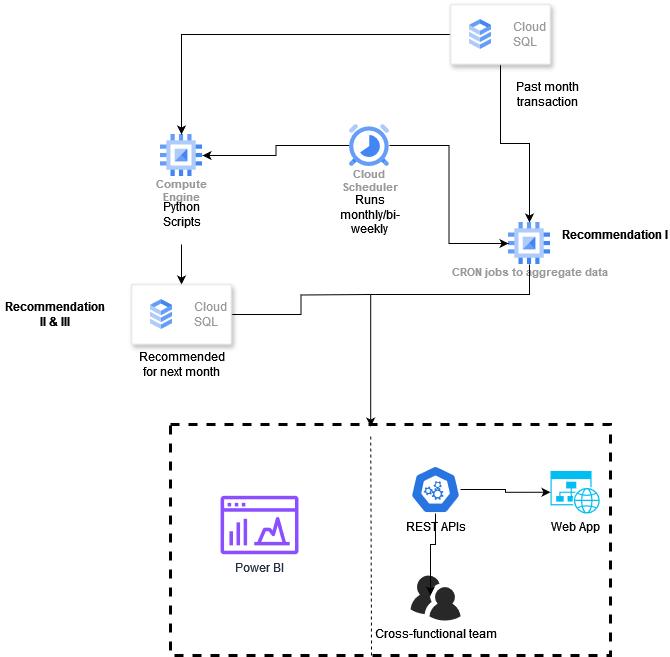

Impact of the proposed system:
- No longer manual work for inventory management
- Implement micro-service which then feds data to power bi. This microservice can be leveraged by other cross-functional teams
- With efficient system, we can automate the process of dispatching products which wont require human in the loop.

In [12]:
# utils
def plot_pie(df,col,title,fig):
    plt.figure(figsize = fig)
#     df[col].value_counts().plot(kind='barh')
#     for index, value in enumerate(df[col].value_counts().to_dict().values()):
#         plt.text(value, index,str(value))

    t = df[col].value_counts(normalize=True).to_dict()
    plt.pie(t.values(), labels=t.keys(), autopct='%1.1f%%')
    plt.title(title)
    plt.show()
    
def recommend_products(market_id,df):
    recommend_data_series = df.groupby(['UNIQUE_MARKET_ID','PRODUCT_NAME'])['QUANTITY_SOLD'].sum()
    recommend_data_series.rename('total_sales',inplace=True)
    recommend_data_df = recommend_data_series.reset_index()

    recommend_data_df = recommend_data_df.pivot_table(values='total_sales',index='UNIQUE_MARKET_ID',columns='PRODUCT_NAME', fill_value=0)

    recommend_data_df_t = recommend_data_df.T

    svd = TruncatedSVD(n_components=10,random_state=1)
    decomposed_matrix = svd.fit_transform(recommend_data_df_t)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    
    recommended_products_list = []
    product_list =list(df[df['UNIQUE_MARKET_ID']==market_id]['PRODUCT_NAME'].unique())
    for product in product_list:
        product_names = list(recommend_data_df_t.index)
        product_ID = product_names.index(product)

        correlation_product_ID = correlation_matrix[product_ID]
        recommended = list(recommend_data_df_t.index[correlation_product_ID > 0.97])

        recommended.remove(product) 
        # Take only top 10 products
        recommended_products_list.extend(recommended[0:9])
        
    
    return (product_list, list(set(recommended_products_list)))